In [278]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats 
import matplotlib
import matplotlib.pyplot as plt
import os
import random
import math
from math import pi
import seaborn as sns
# %matplotlib inline

from IPython.display import Image


# DATA ANALYSIS IN ECOLOGY: EMERGENT PATTERNS

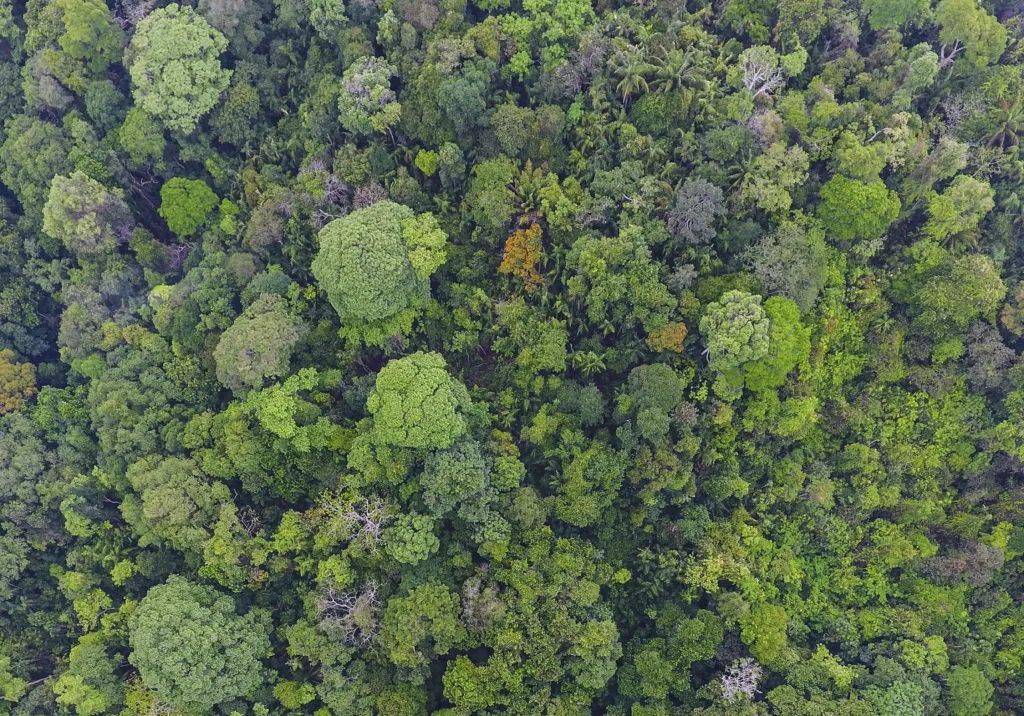

In [279]:
Image(filename='/Users/jacopopasqualiniyahoo.it/Downloads/TropicalForest.jpg',height=600,width=600) 

### To load your data, pandas is the best!

In [505]:
DATA_FOLDER='/Users/jacopopasqualiniyahoo.it/Downloads'
barro = pd.read_excel(os.path.join(DATA_FOLDER,'BCI_abundance_data1982-2005.xlsx'))

In [506]:
barro.head()

,Species Name,Family,1982,1985,1990,1995,2000,2005
0,Abarema macradenia,Fabaceae:Mimos.,1,1,1,1,1,1
1,Acacia melanoceras,Fabaceae:Mimos.,2,1,2,3,2,2
2,Acalypha diversifolia,Euphorbiaceae,2,4,2,2,2,1
3,Acalypha macrostachya,Euphorbiaceae,2,0,2,1,2,2
4,Adelia triloba,Euphorbiaceae,115,114,106,92,81,71


In [507]:
abundances=barro[[1982, 1985, 1990, 1995, 2000, 2005]].values

In [508]:
S,N=abundances.shape
print("Species :",S,"Steps :",N)

Species : 253 Steps : 6


## First "universal pattern" in ecology

# Fisher Log-Series

#### Probabilty density:

$$P_{\nu}(n) = -\frac{1}{\log(1-\nu)}\frac{\nu^n}{n}$$

#### We can find the $\nu$ parameter matching observed with expected mean

$$ \frac{1}{N} \sum_{i=1}^{N} n_i = \mu = -\frac{\nu}{(1-\nu)\log(1-\nu)} \longrightarrow  \frac{\nu}{(1-\nu)\log(1-\nu)} + \mu = 0  $$

$$ \nu + \mu (1-\nu)\log(1-\nu) = 0$$

We need to find zeros of the function:

$$f_{\mu}(\nu)=  \nu + \mu (1-\nu)\log(1-\nu)$$

To apply newton method we need to calculate its derivative respect to $\nu$

$$f'_{\mu}(\nu)=  1 + \mu(1-\log(1-\nu) )$$

# To find the root of an equation, we can use the Newton method

Suppose you have a function $$y=f(x)$$ and that you have a guess for one of its roots $f(x_0) \approx 0$

It can be shown that, under certain conditions, a better approximation is:

$$x_1 = x_0 - \frac{f(x_0)}{f'(x_0)}$$

We obtain tne Newton Method, by iterating this rule:

$$x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}$$


In [537]:
# the mean
def Lr(n):
   def f(r):
       return r+n*(1-r)* math.log(1-r)
   return f

# the derivative of the mean
def dLr(n):
   def f(r):
       return 1+n*((1+r)/(1-r)-math.log(1-r))
   return f

# newton method
def newton(f,df,T,x_inf,x_sup):
    
    x = 0.5*(x_inf+x_sup)
    
    for i in range(T): x = x - f(x)/df(x)
        
    return x

def log_series(n,nu):
    
    return -1/(np.log(1-nu)) * ( (nu)**n / n )

165.0671936758893
0.9944867574386321


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.


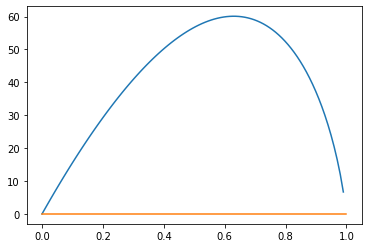

In [538]:
# consider one particular snapshot of your data
samples=abundances[:,:1]

# get the mean
mu=np.mean(samples)

print(mu)

x=np.linspace(0,1,100)
y=-x-mu*(1-x)* np.log(1-x)

plt.plot(x,y)
plt.plot(x,np.zeros(100))

r=newton(f=Lr(n=mu),df=dLr(n=mu),T=100,x_inf=0.2,x_sup=1.0)

print(r)

# Let's see if the momentum method + Newton works:

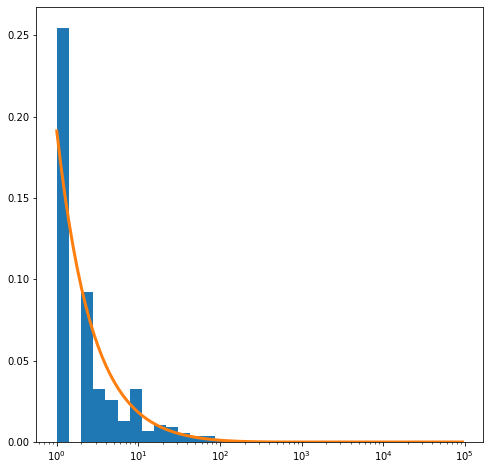

In [540]:
samples=samples[samples>0]
x = np.logspace(np.log(np.min(samples)),0.5*np.log(np.max(samples)),100)# np.linspace(np.min(samples),np.max(samples))
y = log_series(x,r)

N_bins=30
bins_log10 = np.logspace(np.log10(samples.min()), np.log10(samples.max()), N_bins)

fig, ax = plt.subplots(1,figsize=(8,8))
counts, bin_edges, ignored = ax.hist(bins=bins_log10,x=samples,density=True)
ax.plot(x,y,linewidth=3)
ax.set_xscale('log')

# SE PER ESEMPIO NU LO MODIFICHIAMO FAI VEDERE COME SI CORREGGE LA CURVA C'E' un tradoff e vi potetedivertire con la statisticaaaaa

Here emerges the rare species estimation problem ( solution attempt: negative binomial )

Not satisfied? Have fun with statistics! ($\chi^2$ test and so on...)

# Can we get insights from temporal data by simply plotting the time evolution of ALL species?

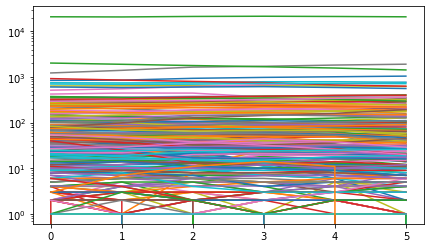

In [541]:
fig, ax = plt.subplots(1,figsize=(7,4))

for s in range(S):
    
    ax.plot(np.arange(N),abundances[s,:].T,label='log')

ax.set_yscale('log')

### The temporal behaviour seems messy. The simpler thing to do is averaging over time.

Second ecological pattern: mean relative abundance is Log-Normal distributed.

We need to work a little bit with logarithmic bins

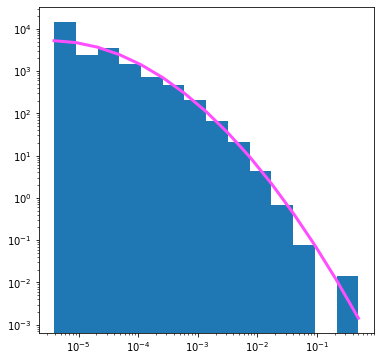

In [545]:
N_bins=15

relative_abundances=abundances/np.sum(abundances,axis=0)
samples=np.mean(relative_abundances,axis=1)

mi=samples.min()
ma=samples.max()

bins_log10 = np.logspace(np.log10(mi), np.log10(ma), N_bins)
bins_log10_cntr = (bins_log10[1:] + bins_log10[:-1]) / 2

shape, loc, scale = stats.lognorm.fit(samples, floc=0)
samples_fit_log = stats.lognorm.pdf(bins_log10, s=shape,loc=loc, scale=scale)

fig, ax = plt.subplots(1,figsize=(6,6))
counts, bin_edges, ignored = plt.hist(bins=bins_log10,x=samples,density=True)

bins_log_cntr = bin_edges[1:] - bin_edges[:-1]
log_area_hist = (bins_log_cntr * counts).sum()

ax.plot(bins_log10, samples_fit_log * log_area_hist, '-', color='#FF4DFF',label='PDF with edges',  linewidth=3)

ax.set_xscale('log')
ax.set_yscale('log')

### Another widely considered pattern is the relative abundance rank

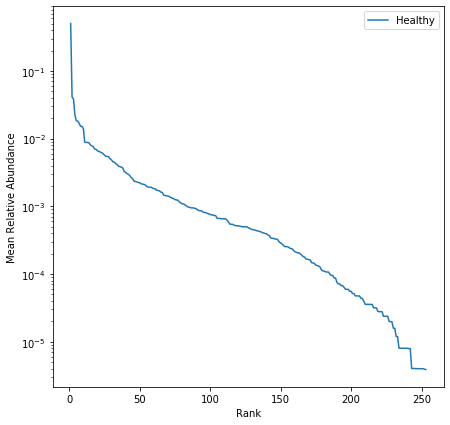

In [511]:
S,N=abundances.shape

rank_mu = np.arange(S)+1
    
mu =np.mean(abundances/np.sum(abundances,axis=0),axis=1)
mu_order = mu.argsort()[::-1]
mu = mu[mu_order]
    
fig, ax1 = plt.subplots(figsize=(7,7))    
fig.patch.set_facecolor('white')
    
ax1.plot(rank_mu,mu,label='Healthy')
ax1.set_xlabel('Rank'); ax1.set_ylabel('Mean Relative Abundance')
ax1.legend()
ax1.set_yscale('log');

### MEAN AND VARIANCE ARE LINKED BY SCALING: TAYLOR LAW

In [512]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [551]:
# we need to remove outliers, this is a kind of art and intuition, cross your fingers

mean=np.mean(abundances/np.sum(abundances,axis=0),axis=1)
sigma=np.var(abundances/np.sum(abundances,axis=0),axis=1)

mean=np.delete(mean,np.argmax(mean))
sigma=np.delete(sigma,np.argmax(mean))

mean=np.delete(mean,np.argmin(sigma))
sigma=np.delete(sigma,np.argmin(sigma))

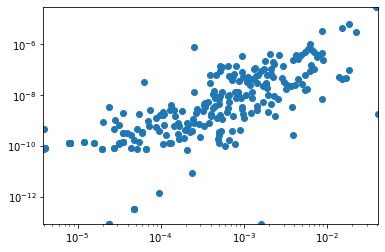

In [557]:
# let's to simple plot

plt.scatter(mean,sigma)
plt.xlim([np.min(mean),np.max(mean)])
plt.ylim([np.min(sigma),np.max(sigma)])
plt.xscale('log')
plt.yscale('log')
plt.show()

## it is not clear, but we can at least see what the scale of proportionality is with a linear fit

-10.476007023899303 1.1557241623837249


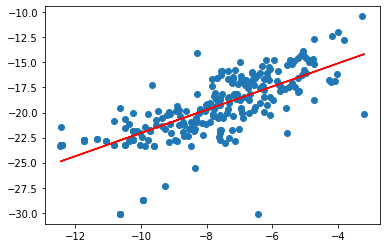

In [561]:
x=np.log(mean.reshape((S-2,1)))
y=np.log(sigma.reshape((S-2,1)))
plt.scatter(x,y)

taylor_reg = linear_model.LinearRegression()

taylor_reg.fit(x,y)
taylor_reg.get_params()

A, nu = taylor_reg.intercept_[0], taylor_reg.coef_[0][0]
print(A, nu)

plt.plot(np.log(mean),A+nu*np.log(mean),color='r')
plt.show()

### Are these pattern really shared among ecosystems?

Let's load another dataset, this time from amazzonia

In [562]:
DATA_FOLDER='/Users/jacopopasqualiniyahoo.it/Downloads'
amazzonia = pd.read_csv(os.path.join(DATA_FOLDER,'AMAZZONIA_pop.csv'))

In [563]:
amazzonia.head()

,1
0,78
1,31
2,22
3,5
4,19


### recycle some code

In [565]:
abundances=np.array(amazzonia.values).reshape(amazzonia.values.shape[0])

111.66055230800242
0.9940934746226858


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


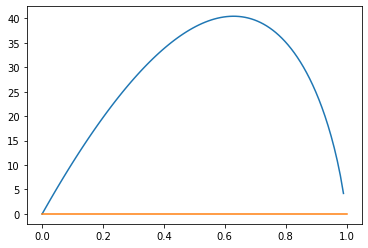

In [566]:
samples=abundances

mu=np.mean(samples)

print(mu)

x=np.linspace(0,1,100)
y=-x-mu*(1-x)* np.log(1-x)

plt.plot(x,y)
plt.plot(x,np.zeros(100))

r=newton(f=Lr(n=mu),df=dLr(n=mu),T=100,x_inf=0.2,x_sup=1.0)

print(r)

### Maybe we can fix the Log-Series shape by hand, but there is atrade off between abundandt and rare species

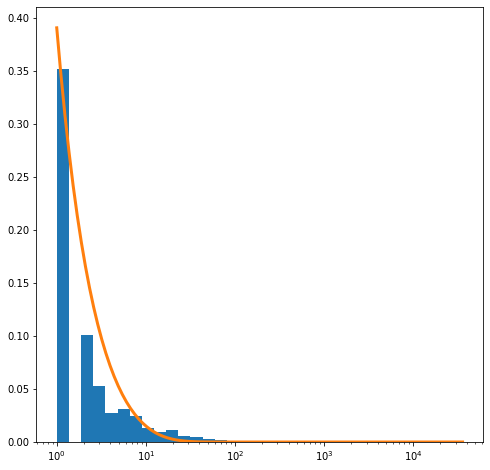

In [568]:
samples=samples[samples>0]
x = np.logspace(np.log(np.min(samples)),0.5*np.log(np.max(samples)),100)# np.linspace(np.min(samples),np.max(samples))

# our distribution
y = log_series(x,0.9)

N_bins=30
bins_log10 = np.logspace(np.log10(samples.min()), np.log10(samples.max()), N_bins)

fig, ax = plt.subplots(1,figsize=(8,8))
counts, bin_edges, ignored = ax.hist(bins=bins_log10,x=samples,density=True)
ax.plot(x,y,linewidth=3)
ax.set_xscale('log')

In [569]:
# plot fluttuazioni? dovrei avere d sigma / d nu > 0

# NETWORKS AS MATRICES AND MATRICES AS NETWORKS

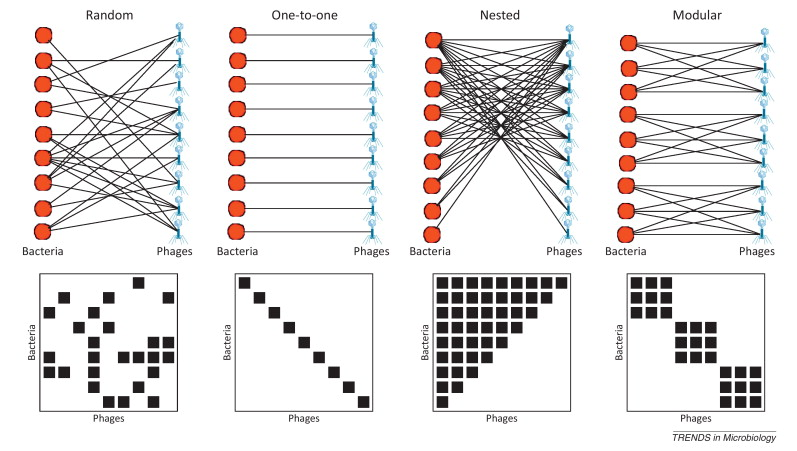

In [579]:
Image(filename='/Users/jacopopasqualiniyahoo.it/Downloads/gr1b1.jpg',height=600,width=600) 

# Can we get insights in biological phenomena by (trying) to simulate them?

## Implementing simple microscopic rules, one may figure out which mecanisms are helpful to let macroscopic patterns emerge

# VOTER MODEL

### Parameters: 

* number of sites = L
* number of species = max_S
* speciation rate = $\nu$
* nuber of time steps = T

### Variables:

SPACE: Consider a squared lattice with side lenght $L$. It will have $L^2$ sites in total
Another key ingredient are the links, which are "roads" to go from one site to another

STATE OF EACH SITE: We choose, according to some criteria, a maximum number of species that can occupy the space.
Each site will be occupied by one species at once. At the beginning only a subset of all the available species (the meatcommunity) will be available but every species will have a chance to appear.

### Dynamics:

INITIAL STATE: for each node chose one random species (with replacement)

DYNAMICS: the dynamics is specified when a substitution rule is given. We will chose one random site of our lattice and change the occupying species according to two rules, which we will usd with a fixed probability. 

*  pick a species from the metacommunity and set it on the chosen site (speciation)

*  pick a species from the neighbourhood of the site and copy it (colonization)

### Sketch of the algorithm:

for each time step:

   $\quad$ randomly choose one site $l$
   
   $\quad$ $ r \sim uniform(0,1)$
   
   $\quad$ $\quad$ if $<nu$:
   
   $\quad$ $\quad$ $\quad$ substitute with speciation
   
   $\quad$ $\quad$ else:
   
   $\quad$ $\quad$ $\quad$ substitute with colonization
    

In [570]:
import networkx as nx

In [589]:
# create positions

L=30

positions = {}

x = np.linspace(0,1,L+1)
x=0.5*(x[1:]+x[:-1])

names = []

for i in range(L):
    for j in range(L):
        node = L*i+j
        names.append(node)
        positions[node]=[round(x[i],2),round(x[j],2)]
        #positions[node]=[x[i],x[j],2]

In [590]:
# give to each species a color

# initial number of species
S = int(L**(1.5))#int(math.sqrt(L))

# metacommunity+local community size
max_S = S + L**2
species_color={}

for s in range(max_S):
    species_color[s]=('#%06X' % random.randint(0, 0xFFFFFF))

In [606]:
# build the graph

net = nx.grid_2d_graph(L, L, periodic=False, create_using=None)
#net = nx.erdos_renyi_graph(n=L**2,p=0.10)

net=nx.convert_node_labels_to_integers(net)

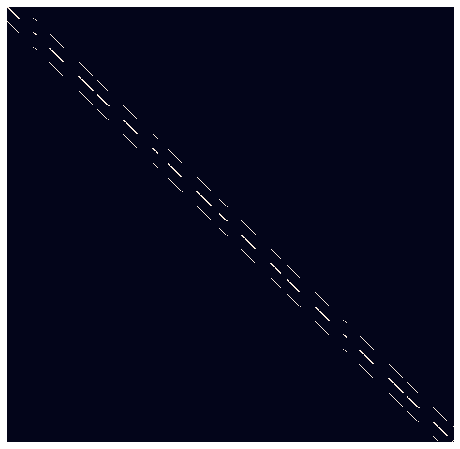

In [607]:
# heatmap

A = nx.to_numpy_array(net)

fig, ax_grid = plt.subplots(1,figsize=(8,8))

sns.heatmap(A,xticklabels=False,yticklabels=False,cbar=False)

# INITIALIZE STATE OF THE SYSTEM

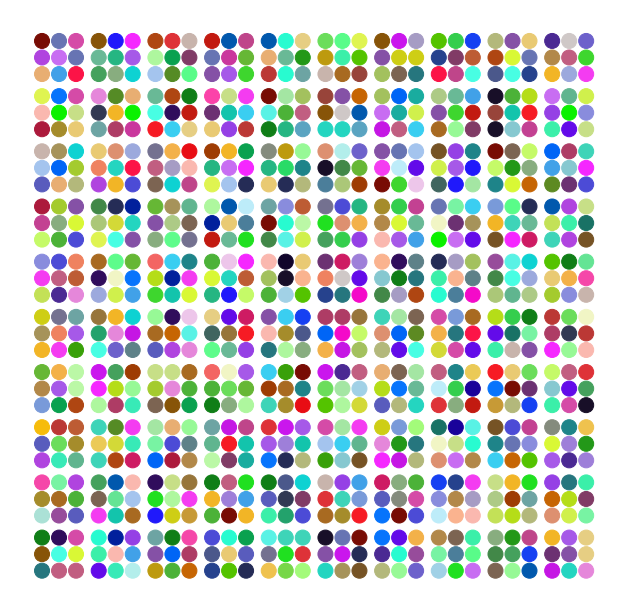

In [619]:
# color each node
# u do not need to cut if the randint is set properly

color_map = []
for node in net:
    s = np.random.randint(0,S)
    color_map.append( species_color[s] )

fig, ax_grid = plt.subplots(1,figsize=(11,11))

clean_labels=dict(zip(np.arange(L**2),['']*L**2))

nx.draw_networkx(net,ax=ax_grid,
                 node_color=color_map,
                 pos=positions,edgelist=False,
                 labels=clean_labels,node_size=0.75*300)
ax_grid.axis("off")
plt.show()

## Data are easier to hande if organized in a pandas dataframe, the python vesion of the excel sheets

In [629]:
# initialize the dataframe
pool=species_color.values()

H = pd.DataFrame(columns=pool)
abundances=dict(pd.Series(color_map).value_counts())
H = H.append(abundances,ignore_index=True)

H.head()

,#B3B87B,#5AA4C1,#C15E81,#0158AD,#CE1B63,#A69CC4,#197265,#CFC8C7,#64E494,#974C9B,...,#221D7E,#2D21EB,#054611,#C2DB53,#F1CD4B,#ABE1B7,#2A49CD,#FF22A9,#2CECD6,#1E36E5
0,5.0,1.0,2.0,7.0,1.0,2.0,1.0,4.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Simulate voter dynamics

In [630]:
nu=0.15

T=1000


for t in range(T):
    
    node = np.random.randint(0,L**2)
    
    if np.random.uniform(0,1) >= nu:
        
        neighbours = np.where( A[node,:]==1)[0]
        spreading = random.choice( neighbours )
        
        color_map[node]=color_map[spreading]
        
    else:
        
        m = np.where( H.loc[0].fillna(0).values==0 )[0]
        metacommunity = [ species_color[i] for i in m ]
        
        color_map[node]=random.choice( metacommunity )
        
    
    abundances=dict(pd.Series(color_map).value_counts())
    H = H.append(abundances,ignore_index=True)

# Plot the time evolution of the system

## See: thermalizatoin + case $\nu=0$ has an absorbing state with one species

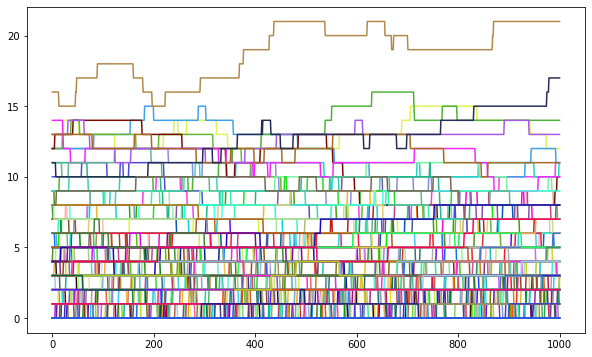

In [631]:
H=H#/L**2
H=H.fillna(0.0)

fig, ax = plt.subplots(1,figsize=(10,6))

species=H.columns.tolist()

for i in range(len(species)):
    plt.plot(np.arange(T+1),H.values[:,i],color=species[i])

## Final state exhibits a cluster structure:

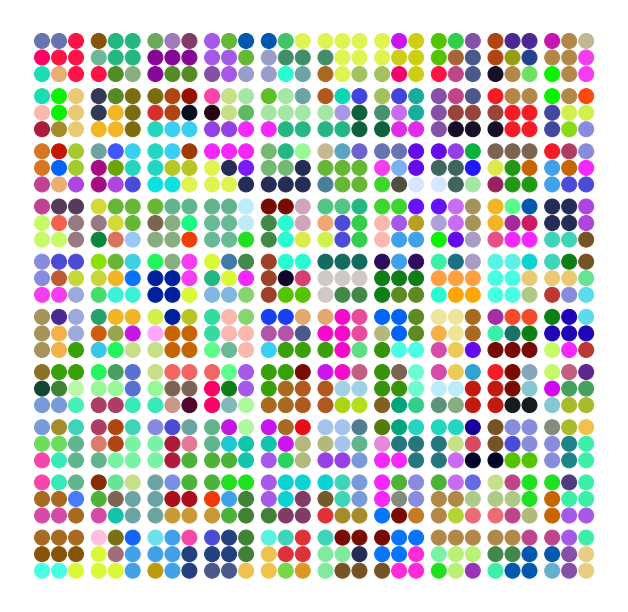

In [627]:
fig, ax_grid = plt.subplots(1,figsize=(11,11))

clean_labels=dict(zip(np.arange(L**2),['']*L**2))

nx.draw_networkx(net,ax=ax_grid,
                 node_color=color_map,
                 pos=positions,edgelist=False,
                 labels=clean_labels,node_size=0.75*300)

ax_grid.axis("off")
plt.show()

## Does VM reproduces log-series?

In [632]:
M=100; burn=500
random_sampling=np.random.choice(np.arange(burn, T), M, replace=False)

samples=H.values[random_sampling]
samples=samples[ samples>0 ]

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


0.8394881985266787


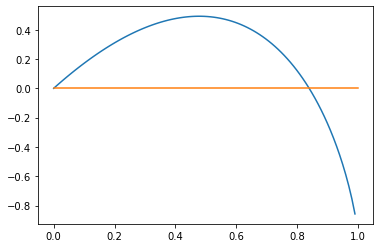

In [633]:
mu=np.mean(samples)
x=np.linspace(0,1,100)
y=-x-mu*(1-x)* np.log(1-x)

plt.plot(x,y)
plt.plot(x,np.zeros(100))

r=newton(f=Lr(n=mu),df=dLr(n=mu),T=100,x_inf=0.4,x_sup=1.0)

print(r)

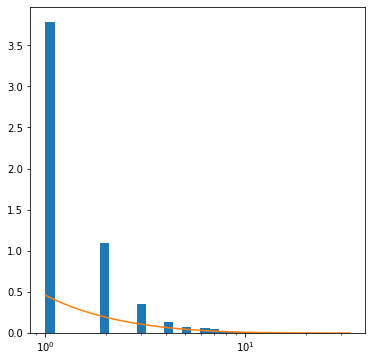

In [634]:
samples=samples[samples>0]
x = np.logspace(np.log(np.min(samples)),0.5*np.log(np.max(samples)),100)# np.linspace(np.min(samples),np.max(samples))
y = log_series(x,r)

N_bins=30
bins_log10 = np.logspace(np.log10(samples.min()), np.log10(samples.max()), N_bins)

fig, ax = plt.subplots(1,figsize=(6,6))
counts, bin_edges, ignored = ax.hist(bins=bins_log10,x=samples,density=True)
ax.plot(x,y)
ax.set_xscale('log')

# WHT'S WRONG IN THIS SIMULATION?



/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


0.9873193231465052


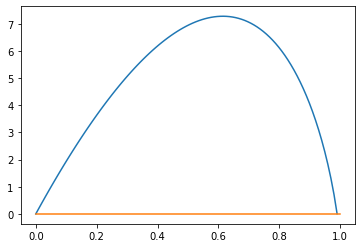

In [635]:
DATA_FOLDER='/Users/jacopopasqualiniyahoo.it/Downloads'
voter = pd.read_csv(os.path.join(DATA_FOLDER,'RSA_nnodi100000.txt'),header=None)

samples=np.array(voter.values).flatten()

mu=np.mean(samples)
x=np.linspace(0,1,100)
y=-x-mu*(1-x)* np.log(1-x)

plt.plot(x,y)
plt.plot(x,np.zeros(100))

r=newton(f=Lr(n=mu),df=dLr(n=mu),T=100,x_inf=0.4,x_sup=1.0)

print(r)

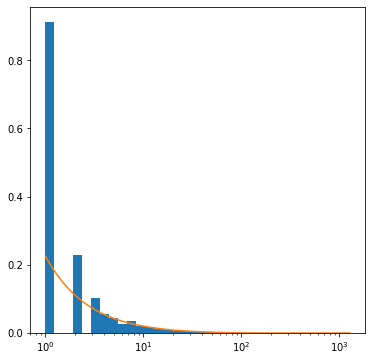

In [636]:
samples=samples[samples>0]
x = np.logspace(np.log(np.min(samples)),0.5*np.log(np.max(samples)),100)# np.linspace(np.min(samples),np.max(samples))
y = log_series(x,r)

N_bins=30
bins_log10 = np.logspace(np.log10(samples.min()), np.log10(samples.max()), N_bins)

fig, ax = plt.subplots(1,figsize=(6,6))
counts, bin_edges, ignored = ax.hist(bins=bins_log10,x=samples,density=True)
ax.plot(x,y)
ax.set_xscale('log')

## Extintion times

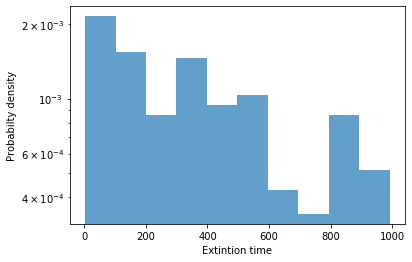

In [637]:
X=H.values

extintion_times=[]
for s in range(max_S):
    
    presence = 1*(X[:,s] > 0)

    t=0

    for p in presence:
    
        if p!=0:
            t+=1
        else:
            if t!=0:
                extintion_times.append(t)
                t=0
                
plt.hist(extintion_times,density=True,alpha=0.7)
plt.xlabel('Extintion time')
plt.ylabel('Probabilty density')
plt.yscale('log')

# ECOLOGY WITH LOTKA VOLTERRA

It's a system of non linear differential equations of the first order that describes species evolution

$$ \frac{dx_k(t)}{dt} = x_k(t) \big( r_k + \sum_{l=1}^{S} A_{k,l}x_l(t) \big ) $$

They are infesible to solve as soon as the number of species grows, so we need to integrate them numerically. We will use the euler method

$$ x_k > 0 \rightarrow u_k = \log (x_k)$$


$$ \frac{du_k(t)}{dt} = r_k + \sum_{l=1}^{S} A_{k,l}e^{u_l(t)} $$

### Euler discretization

$$ \Delta_i = t_{i+1} - t_i \quad \Delta_i u_k = u_k(t_{i+1})-u_k(t_i)$$

$$ \Delta_i u_k \approx \big [r_k +\sum_{l=1}^{S} A_{k,l}e^{u_l(t)} \big ] \Delta_i$$ 

### The stochastic counterpart is slightly more involved, but tractable

$$ \frac{dx_k(t)}{dt} = x_k(t) \big( r_k + \sum_{l=1}^{S} A_{k,l}x_l(t) \big ) + \sigma x_k(t) \eta_k(t) $$

$$ \eta_k(t): \quad \langle \eta_k(t) \rangle = 0 \quad \langle \eta_k(t) \eta_l(t')=\delta_{k,l}\delta(t-t')$$ 

### Change of variables (see Ito formula)

$$ x_k > 0 \rightarrow u_k = \log (x_k)$$

$$ R_k = r_k - \frac{\sigma^2}{2} $$

$$ \frac{du_k(t)}{dt} = R_k + \sum_{l=1}^{S} A_{k,l}e^{u_l(t)} + \sigma \eta_k(t) $$

### Euler discretization

$$ \Delta_i = t_{i+1} - t_i \quad \Delta_i u_k = u_k(t_{i+1})-u_k(t_i)$$

$$ \Delta_i u_k \approx \big [R_k +\sum_{l=1}^{S} A_{k,l}e^{u_l(t)} \big ] \Delta_i + \sigma \sqrt{\Delta_i} \eta_k(t) $$ 

In [643]:
def integrate_GLV(A,r,sigma,x0,T,dt,stochastic=True):
    
    S=x0.shape[0]
    
    if stochastic==False: sigma=0
    
    R = r - sigma**2 / 2
    
    u = np.log(x0)
    
    time = np.zeros(T+1)
    U = np.zeros((T,S))
    
    if stochastic==True:
        
        for t in range(T):
            for k in range(S):
                u[k] = u[k] + (R[k] +  np.sum( np.dot(A,np.exp(u)) )) * dt + sigma*math.sqrt(dt)*np.random.normal(0,1)
        
            U[t,:],time[t+1] = u, time[t]+dt
            
    else:
        
        for t in range(T):
            for k in range(S):
                u[k] = u[k] + (R[k] +  np.sum( np.dot(A,np.exp(u)) )) * dt
        
            U[t,:],time[t+1] = u, time[t]+dt

    time=time[:-1]

    return time,np.exp(U)

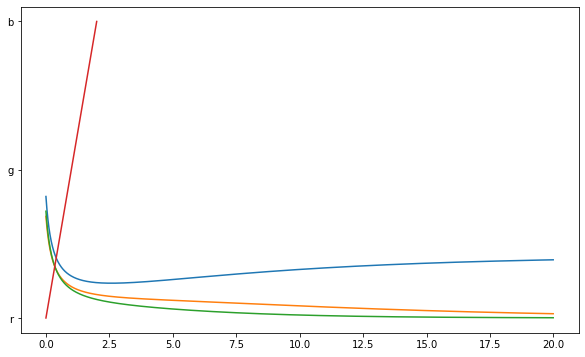

In [647]:
S=3

A=np.random.normal(0,1,(S,S))
np.fill_diagonal(A,-1)

r=np.random.uniform(0,1,S)

x0=np.random.uniform(0,1,S)

sigma=0.1
N=2000

t, X = integrate_GLV(A=A,r=r,sigma=sigma,x0=x0,T=N,dt=.01,stochastic=False)

fig, ax = plt.subplots(1,figsize=(10,6))
ax.plot(t,X,color)
plt.show()

# LOW DIMENSIONAL LOTKA VOLTERRA: DETERMINISTIC VS STOCHASTIC

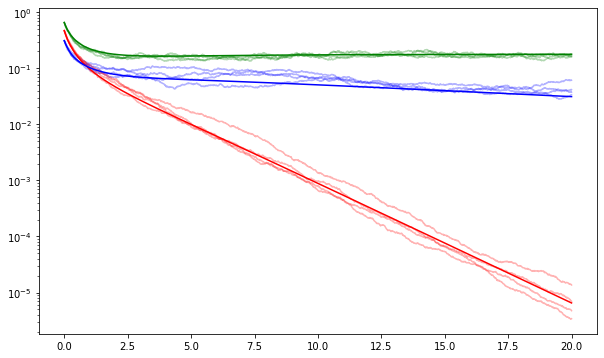

In [649]:
S=3

A=np.random.normal(0,1,(S,S))
np.fill_diagonal(A,-1)

r=np.random.uniform(0,1,S)

x0=np.random.uniform(0,1,S)

sigma=0.1
N=2000
color=['r','g','b']

fig, ax = plt.subplots(1,figsize=(10,6))

for t in range(4):
    
    t, X = integrate_GLV(A=A,r=r,sigma=sigma,x0=x0,T=N,dt=.01,stochastic=True)
    
    for s in range(S):
        ax.plot(t,X[:,s],color=color[s],alpha=0.3)

t, X = integrate_GLV(A=A,r=r,sigma=sigma,x0=x0,T=N,dt=.01,stochastic=False)

for s in range(S):
        ax.plot(t,X[:,s],color=color[s])

ax.set_yscale('log')
plt.show()

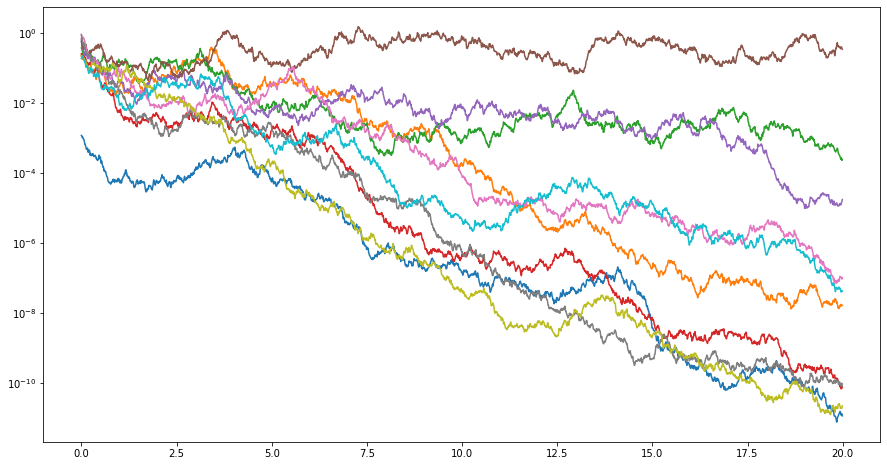

In [650]:
S=10

A=np.random.normal(0,1,(S,S))
np.fill_diagonal(A,-1)

r=np.random.uniform(0,1,S)

x0=np.random.uniform(0,1,S)

sigma=1.0
N=2000

t, X = integrate_GLV(A=A,r=r,sigma=sigma,x0=x0,T=N,dt=.01,stochastic=True)

fig, ax = plt.subplots(1,figsize=(15,8))

ax.plot(t,X)
ax.set_yscale('log')
plt.show()

# THE RETURN OF THE NETWORK: DEFINING DIFFERENT INTERACTIONS TOPOLOGIES

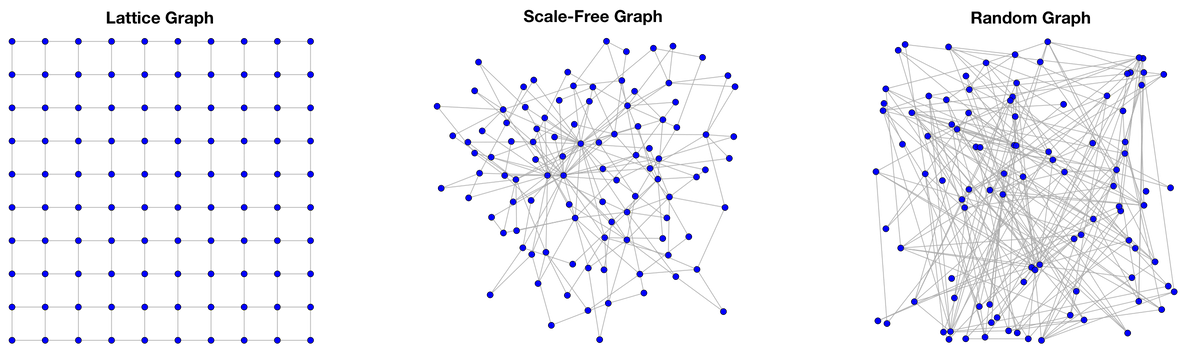

In [582]:
Image(filename='/Users/jacopopasqualiniyahoo.it/Downloads/graph-types.png',height=1000,width=1000) 

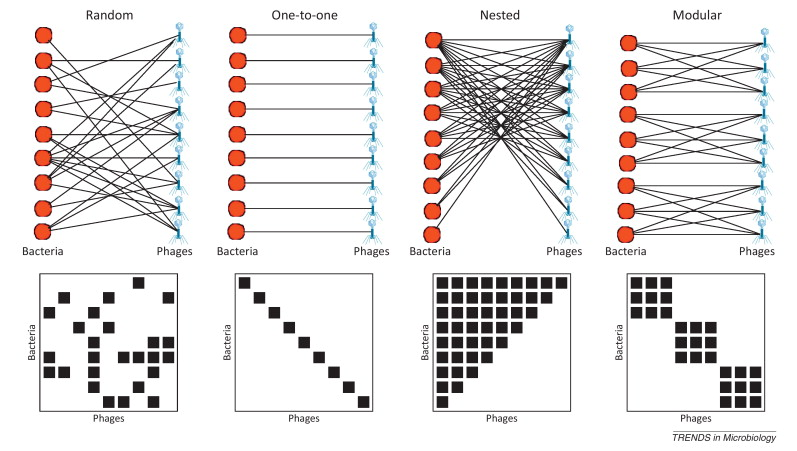

In [583]:
Image(filename='/Users/jacopopasqualiniyahoo.it/Downloads/gr1b1.jpg',height=600,width=600) 

# RANDOM MATRIX THEORY: GUESSING SOMETIMES IS AS USEFUL AS OTHER SOLUTIONS

In [653]:
S=70
C=0.25
sigma=1.5

#net = nx.erdos_renyi_graph(n=S,p=C)
#er_mask = nx.to_numpy_array(net)
    
M = sigma*np.random.normal(0,1,(S,S))
#M = er_mask*M

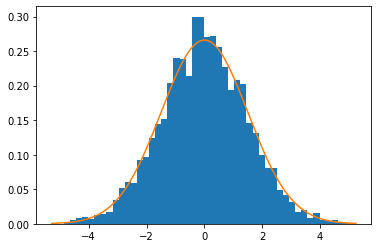

In [654]:
data=M.flatten()
plt.hist(data,bins=50,density=True)

z=np.arange(np.min(data),np.max(data),.001)
gauss=sp.stats.norm.pdf(z,scale=sigma)

plt.plot(z,gauss)
plt.show()

In [655]:
def euler_may(A,T,dt):
    
    S=A.shape[0]
    
    x=np.random.uniform(0,1,S)
    
    x=np.zeros((T,S))
    
    x[0,:]=np.random.uniform(0,1,S)
    
    for t in range(1,T):
        
        x[t,:]=x[t-1,:]+np.dot(A,x[t-1,:])*dt
    
    fig, ax = plt.subplots(1,figsize=(8,5))
    ax.plot(np.arange(T)*dt,x)
    ax.set_title('May experiment: integrate dx/dy=Ax')
    plt.show()

# Say welcome to the complexity-stability paradox: as the number of species grows the system becomes more and more unsable

### We are going to simulate the behaviour of the system $\frac{dx}{dt}=Ax$

### May "experiment": what happens if i randomly build my system?

### Three parameters

* Number of species = S
* Standard deviation of the gaussian = $\sigma$
* Netowkr connectivity = C
* Diagonal elements magnitude = d
* Other rules...?


In [663]:
def random_community(S,sigma,C,d):
    
    net = nx.erdos_renyi_graph(n=S,p=C)
    er_mask = nx.to_numpy_array(net)

    A = sigma*np.random.normal(0,1,(S,S))
    A=A*er_mask

    np.fill_diagonal(A,d)
    
    return A

# THE CIRCLE LAW

Expected pair product : EP = 0  Pair product: E = -0.04085786895667399


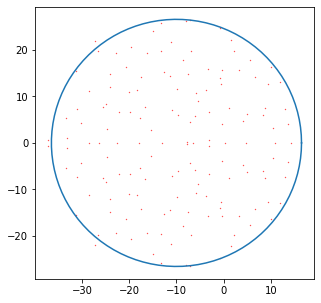

Max Species: S_c =  21.333333333333332
Stability:  False


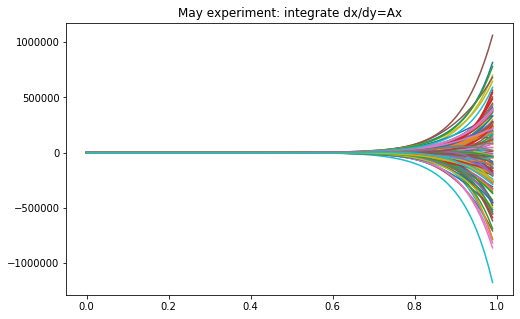

In [664]:
S=150
C=0.75
sigma=2.5#1/math.sqrt(S)
 
d=10
M=random_community(S,sigma,C,-d)

ex_pair=0
pair=pair_product(M)
print("Expected pair product : EP =",ex_pair," Pair product: E =",pair)

fig, ax = plt.subplots(1,figsize=(5,5))

spectrum=np.linalg.eigvals(M)
Re=spectrum.real
Im=spectrum.imag

ax.scatter(Re,Im,color='r',s=0.1)

theta = np.linspace(0,2*pi,100)
radius= sigma*math.sqrt(C*S)

ax.plot(radius*np.cos(theta)-d,radius*np.sin(theta))

plt.show()

print('Max Species: S_c = ',(d/sigma)**2 * (1/C))
print('Stability: ',(sigma*math.sqrt(S*C)<d))

euler_may(M,T=100,dt=0.01)

In [670]:
def may_experiment(A,ro,T,dt,circle=True):
    
    spectrum=np.linalg.eigvals(A)
    Re=spectrum.real
    Im=spectrum.imag

    fig, ax = plt.subplots(1,figsize=(7,7))

    xs=np.max(Re)*1.2; ys=np.max(Im)*1.2
    ax.set_xlim([-1.5*xs-d,1.5*xs-d]); ax.set_ylim([-1.5*ys,1.5*ys])
    ax.set_xlabel('Re'); ax.set_ylabel('Im')
    ax.set_title('Circle law')
    
    if circle==True:
        theta = np.linspace(0,2*pi,100); radius= sigma*math.sqrt(C*S)
        ax.plot(radius*(1+ro)*np.cos(theta)-d,radius*(1-ro)*np.sin(theta))

    ax.scatter(Re,Im,color='r',s=0.3)
    ax.plot(np.zeros(100),np.linspace(-ps,ps,100),alpha=0.5)

    plt.show()
    
    euler_may(A=A,T=T,dt=dt)

#  PREY/PREDATOR MATRICES

In [666]:
def prey_predator(S,sigma,C,d):
    
    net = nx.erdos_renyi_graph(n=S,p=C)
    er_mask = nx.to_numpy_array(net)

    A = sigma*np.random.normal(0,1,(S,S))
    A=A*er_mask
    
    for i in range(S):
        for j in range(i+1,S):

            if A[i,j]>0: A[j,i]=-abs(A[j,i])
            else: A[j,i]=abs(A[j,i])
                
    np.fill_diagonal(A,d)
                
    return A

ro =  -0.6366197723675814
Max Species: S_c =  143.43115385858803
Stability:  False


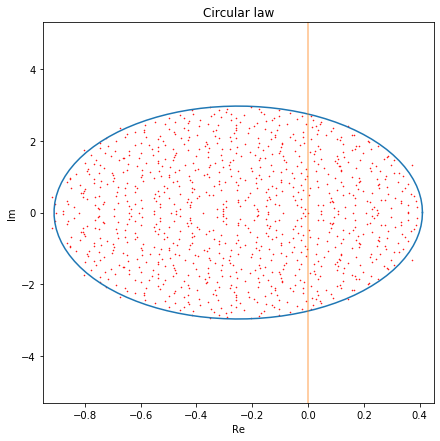

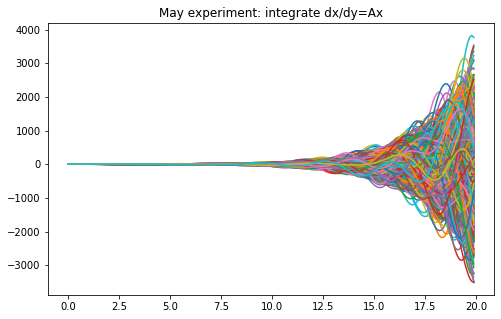

In [667]:
S=1000
C=0.33
sigma=0.1#1/math.sqrt(S)
d=0.25

V=prey_predator(S,sigma,C,-d)
ro=-2/pi
print("ro = ",ro)

# stability
print('Max Species: S_c = ',(d/sigma)**2 * (pi/(pi-2))**2  * (1/C))
print('Stability: ',(sigma*math.sqrt(S*C)<d*pi/(pi-2)))

may_experiment(A=V,ro=ro,T=200,dt=0.1)

# MUTUALISTIC/COMPETITION MATRICES

In [671]:
def mutualistic(S,sigma,C,d):
    
    net = nx.erdos_renyi_graph(n=S,p=C)
    er_mask = nx.to_numpy_array(net)

    A = sigma*np.random.normal(0,1,(S,S))
    A=A*er_mask
    
    for i in range(S):
        for j in range(i+1,S):

            if A[i,j]>0: A[j,i]=-abs(A[j,i])
            else: A[j,i]=abs(A[j,i])
                
    np.fill_diagonal(A,d)
    
    A=np.abs(A)
                
    return A

def competition(S,sigma,C,d):
    
    net = nx.erdos_renyi_graph(n=S,p=C)
    er_mask = nx.to_numpy_array(net)

    A = sigma*np.random.normal(0,1,(S,S))
    A=A*er_mask
    
    for i in range(S):
        for j in range(i+1,S):

            if A[i,j]>0: A[j,i]=-abs(A[j,i])
            else: A[j,i]=abs(A[j,i])
                
    np.fill_diagonal(A,d)
    
    A=-1.0*np.abs(A)
    
    return A

ro =  0.6366197723675814
Max Species: S_c =  6.044580006082313
Stability:  False


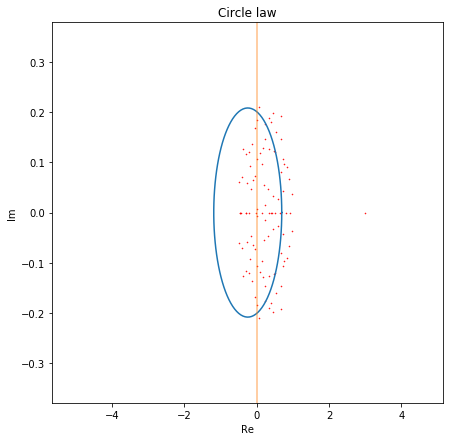

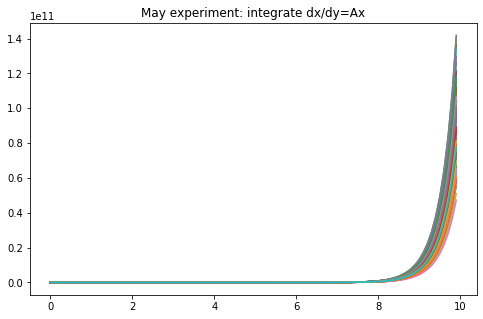

In [672]:
S=100
C=0.33
sigma=0.1#1/math.sqrt(S)
d=0.25

compete=False
V = mutualistic(S,sigma,C,-d) 

ro=2/pi
print("ro = ",ro)

# stability
if compete==True:
    print('Max Species: S_c = ',((2+pi)/pi)**2 * (d/sigma - math.sqrt(2/pi)) )
    print('Stability: ',(sigma*( math.sqrt(S)*pi/(2+pi) + math.sqrt(2/pi)) < d ))  
else:
    print('Max Species: S_c = ',d/(sigma*C)*math.sqrt(2/pi))
    print('Stability: ',(sigma*S*C<d*math.sqrt(2/pi)) )
    
avg_pair = may_experiment(A=V,ro=ro,T=100,dt=0.1)

# print("Expected pair product : EP=",-2*sigma**2/pi," Pair product: E=",avg_pair)

# BIPARTITE MATRICES

In [673]:
def bipartite(S,C,sigma,d):

    V=np.zeros((S,S))
    
    C1=2*C*(S-1)/S
    
    half=int(S/2)
    
    net1 = nx.erdos_renyi_graph(n=half,p=C1)
    er_mask1 = nx.to_numpy_array(net1)

    AB = sigma*np.random.normal(0,1,(half,half))
    AB = AB*er_mask1
    
    net2 = nx.erdos_renyi_graph(n=half,p=C1)
    er_mask2 = nx.to_numpy_array(net2)

    BA = sigma*np.random.normal(0,1,(half,half))
    BA = BA*er_mask2
    
    V[half:,:half]=AB
    V[:half,half:]=BA
    
    V=np.abs(V)
    np.fill_diagonal(V,d)
    
    return V

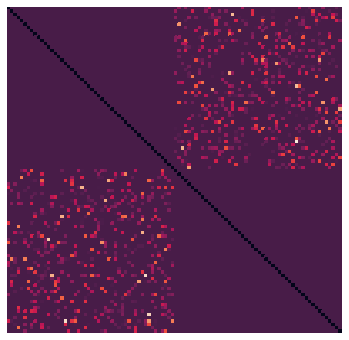

In [674]:
S=100
fig,ax = plt.subplots(1,figsize=(6,6))

sns.heatmap(bipartite(S,sigma,C,-d),ax=ax,xticklabels=False,yticklabels=False,cbar=False )

ro =  0.6366197723675814


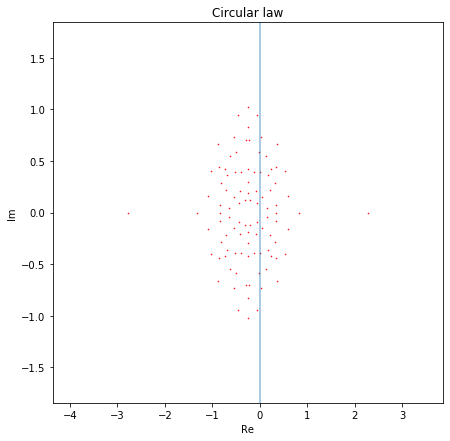

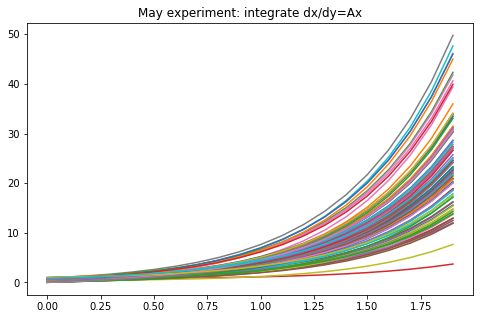

In [366]:
S=100
C=0.33
sigma=0.1#1/math.sqrt(S)
d=0.25

compete=False
V = bipartite(S,sigma,C,-d) 

ro=2/pi
print("ro = ",ro)

# stability

avg_pair = may_experiment(A=V,ro=ro,T=20,dt=0.1,circle=False)

# print("Expected pair product : EP=",-2*sigma**2/pi," Pair product: E=",avg_pair)

# BIPARTITE + NESTED MATRICES

In [675]:
def bipartite_nested(S1,S2,d,sigma,C):
    S=S1+S2

    M=np.zeros((S,S))

    M[S2:,:S2]=nested(S1,S2,sigma)
    M[:S2,S2:]=nested(S2,S1,sigma)

    M=np.abs(M)
    
    net = nx.erdos_renyi_graph(n=S,p=C)
    er_mask = nx.to_numpy_array(net)
    M=M*er_mask
    
    np.fill_diagonal(M,d)
    
    return M

def nested(Sr,Sc,sigma):
    N=np.zeros((Sr,Sc))
    l=0
    while l<min(Sr,Sc):
        if min(Sr,Sc)-2*l>0:
            N[l:Sr-l,l]=sigma*np.random.normal(0,1,Sr-2*l)
            N[l,l+1:Sc-l]=sigma*np.random.normal(0,1,Sc-2*l-1)
            l+=1
        else: break
        
    return N

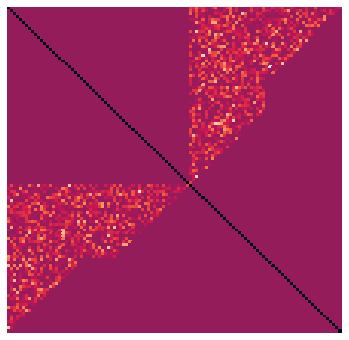

In [676]:
fig,ax = plt.subplots(1,figsize=(6,6))

sns.heatmap(bipartite_nested(S1=50,S2=60,d=-5,sigma=2.5,C=0.75),ax=ax,xticklabels=False,yticklabels=False,cbar=False )

ro =  0.6366197723675814


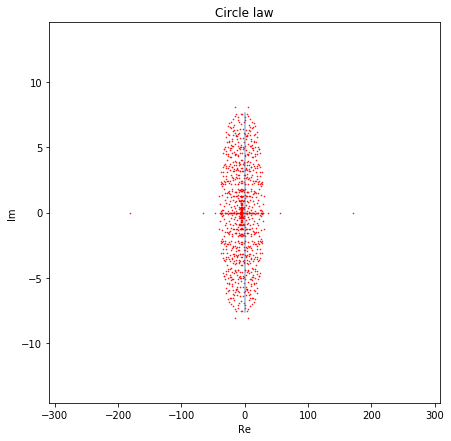

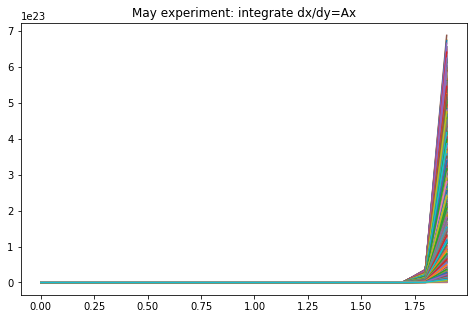

In [677]:
S=500
C=0.33
sigma=0.1#1/math.sqrt(S)
d=0.25

compete=False
V = bipartite_nested(S1=500,S2=600,d=-5,sigma=2.5,C=0.25)

ro=2/pi
print("ro = ",ro)

# stability

avg_pair = may_experiment(A=V,ro=ro,T=20,dt=0.1,circle=False)

# Have we learned something about Lotka Volterra?

# The truth is:

$$ \frac{dx_k(t)}{dt} = f_k(x) = x_k(t) \big( r_k + \sum_{l=1}^{S} A_{k,l}x_l(t) \big ) $$

### Equilibria:

$$ \frac{dx_k(t)}{dt} = 0 = f_k(x*) \longrightarrow x^*_k(t) \big( r_k + \sum_{l=1}^{S} A_{k,l}x^*_l(t) \big ) = 0 $$

With matrix formalism:

$$X^* = - A^{-1} r$$

### Linearization: 

$$ \frac{dx(t)}{dt} = A x \quad A_{i,j} = \frac{\partial f_i(x)}{\partial x_j}(x^*) = A_{ij} x^*_j $$

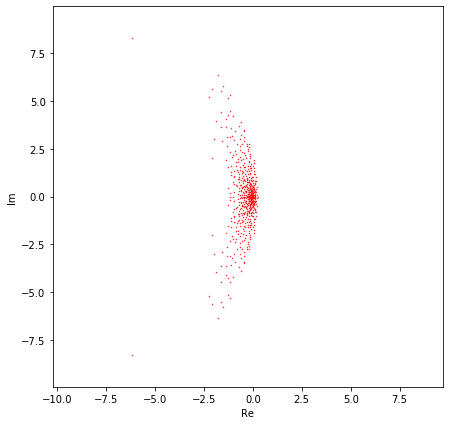

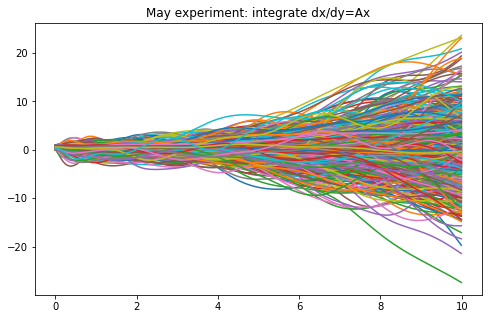

In [678]:
S=500; C=0.33; sigma=0.1; d=0.25

M=prey_predator(S,sigma,C,-d)
X=np.diag(np.random.lognormal(size=S))
M=np.dot(X,M)

spectrum=np.linalg.eigvals(M)
Re=spectrum.real; Im=spectrum.imag

fig, ax = plt.subplots(1,figsize=(7,7))

ax.scatter(Re,Im,color='r',s=0.2)

ps=np.max(Im)*1.2
ax.set_xlim([-ps-d,ps-d]); ax.set_ylim([-ps,ps])
ax.set_xlabel('Re'); ax.set_ylabel('Im')

plt.show()

euler_may(M,1000,0.01)